In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [15]:
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
#Load full dataset
data_dir = "dataset"
dataset = ImageFolder(data_dir, transform=val_transforms)

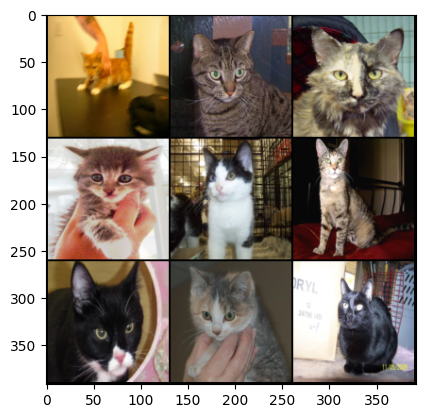

In [17]:
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
images, labels = next(iter(loader))
grid = torchvision.utils.make_grid(images[:9], nrow=3, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0))

In [18]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128x128) -> (64x64)

            nn.Conv2d(16, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64x64) -> (32x32)

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32x32) -> (16x16)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # binary classification
        ) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [19]:
model = BasicCNN().to(device)
model.load_state_dict(torch.load('weights.pth')["model_state_dict"])
model.eval()

BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_f

In [20]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Total learnable parameters: 2121346


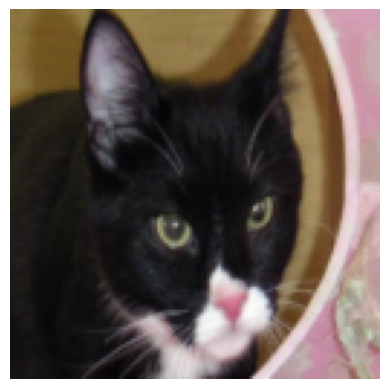

The model classified the image as a(n) dog with a confidence of 0.6246059536933899 and it's a(n) cat


In [21]:
image, label = dataset[6]
imshow(image)
image = image.unsqueeze(0).to(device)
logits = model(image)
confidence, prediction = torch.max(F.softmax(logits, dim=1), dim=1)
classification = lambda e: "cat" if e==0 else "dog"
print("The model classified the image as a(n)", classification(prediction), "with a confidence of", confidence.item(), "and it's a(n)", classification(label))